## 7 - Калибровка

### 7.1 - Библиотеки

In [1]:
import pandas as pd
import numpy as np

import yaml
import io

import scipy.optimize as optimize
import pandas as pd
import numpy as np

from _utils.calibrate_tests import *
from _utils.model_test_functions import *
from _utils.text_preporation import (master_scale, reverse_scale)

from calibration_helper import *

import yaml 

import warnings
warnings.filterwarnings("ignore")

### 7.2 - Пути

In [2]:
with open('../CONFIGS.yaml', 'r', encoding='utf-8') as file:
    CONFIG = yaml.safe_load(file)

PATHS = CONFIG['data_paths']

In [3]:
filepath = {
      'integral_model_preds'  : PATHS['model_integral']['predictions']['raw']
    , 'base_model_preds'      : PATHS['model_base']['predictions']
    , 'gov_influence'         : PATHS['module_gov']['influence']
    , 'group_influence'       : PATHS['module_group']['influence']
    , 'warning_signals'       : PATHS['module_warnings']['final']
    , 'warning_signals_raw'   : PATHS['module_warnings']['raw_data']
    , 'master_scale'          : PATHS['ratings']['master_scale']
    , 'calibrated_predictions': PATHS['model_integral']['predictions']['calibrated']
}

### 7.3 - Чтение данных

In [4]:
df        = pd.read_parquet(filepath['integral_model_preds'])
data      = pd.read_parquet(filepath['base_model_preds'])
gov_df    = pd.read_parquet(filepath['gov_influence'])
group_df  = pd.read_parquet(filepath['group_influence'])
signal_df = pd.read_parquet(filepath['warning_signals'])
master    = pd.read_excel(filepath['master_scale'])
master.rename(columns = {  'Рейтинг':'rating'
                         , 'Нижний предел':'lower_bound'
                         , 'Вероятность Дефолта': 'pd'
                         , 'Верхний предел':'upper_bound' }, inplace=True)

warnings_df = pd.read_excel(filepath['warning_signals_raw'])
warnings_df = warnings_df.rename(columns = {'Код интеграции': 'signal', 'Ухудшение рейтинга': 'current_rating'})
warnings_df = warnings_df[['signal', 'current_rating']]
warnings_df['signal_type']  = np.where(warnings_df['current_rating'] < 17, 'additive', 'target')

In [5]:
# df_w = pd.read_parquet(PATHS['ratings']['weights'])

In [6]:
target_col = 'target'
weight_col = 'W_norm'
# weight_col = 'W'

In [7]:
TTC_value  = CONFIG['calibration_params']['central_tendency']['TTC'] 
PIT_value  = CONFIG['calibration_params']['central_tendency']['PIT']
df['integral_model_preds'].mean(), TTC_value, PIT_value

(np.float64(0.06412773475120385), 0.05504190055045175, 0.05273895123991376)

### 7.4 - Обработка данных

In [8]:
warnings_cols_to_drop = ['kws13', 'kws15', 'DT0300', 'DT1100', 'DT0100']
warnings_df = warnings_df.query('signal not in @warnings_cols_to_drop')
warnings_df = warnings_df.drop_duplicates()

In [9]:
df = pd.merge(df,
              data,
              how='inner',
              on=['client_id', 'rating_id', target_col, weight_col])

df = pd.merge(df,
              gov_df,
              how='inner',
              on=['rating_id'])

df = pd.merge(df,
              group_df,
              how='inner',
              on=['rating_id'])

In [10]:
df['base_model_logits'] = np.log(1/(df['base_model_preds'])-1)*-1

### 7.5 - Калибровка

In [11]:
def calibrated_sigmoid(logits, slope, intercept):
    return 1 / (1 + np.exp(-1 * (intercept + slope * logits)))

def find_slope_and_intercept(  initial_guess
                             , logits
                             , optimal
                             , verbose=False):
    
    def f(params, logits, optimal):
        "Найти параметры slope, intercept для сигмоидной функции, чтобы средняя предсказанная PD равнялась additive_optimal."
        slope, intercept = params
        
        return (optimal - (1 / (1 + np.exp(-1*(intercept + slope * logits)))).mean()) ** 2


    result = optimize.minimize(
        f, 
        initial_guess,
        args=(logits, optimal)
    )

    if result.success:
        fitted_params = result.x
    else:
        raise ValueError(result.message)

    slope     = fitted_params[0]
    intercept = fitted_params[1]
    if verbose:
        print('Получившиеся коэффициенты')
        print('Slope =', slope)
        print('Intercept = ', intercept)

    return slope, intercept

In [12]:
sp = {} #search_params
coeffs = {}

#### 7.5.1 - TTC

In [13]:
sp['TTC'] = {
      'initial_guess' : [-0.5, -0.55]
    , 'logits'        : df['base_model_logits']
    , 'optimal'       : TTC_value - (np.mean(df['integral_model_preds']) - TTC_value)
}
# print('Приблизительный оптимум:', additive_optimal_TTC)

In [14]:
coeffs['TTC'] = {}
coeffs['TTC']['slope'], coeffs['TTC']['intercept'] =\
      find_slope_and_intercept(  sp['TTC']['initial_guess']
                               , sp['TTC']['logits']
                               , sp['TTC']['optimal']
                               , verbose=True)

df['TTC'] = calibrated_sigmoid(  df['base_model_logits']
                                 , coeffs['TTC']['slope']
                                 , coeffs['TTC']['intercept'])

Получившиеся коэффициенты
Slope = 0.7022088890336418
Intercept =  -0.9339255483425418


#### 7.5.2 - PIT

In [15]:
pit_date_start = '2023-07-01'
pit_date_end   = '2024-07-01'

pit_df = df.query('rating_assignment_date >= @pit_date_start and rating_assignment_date < @pit_date_end')

pit_df['base_model_preds_adj'] = df.query('rating_assignment_date >= @pit_date_start and rating_assignment_date < @pit_date_end')['base_model_preds_adj']
pit_df['integral_model_preds'] = df.query('rating_assignment_date >= @pit_date_start and rating_assignment_date < @pit_date_end')['integral_model_preds']

In [16]:
additive_optimal_PIT = 0.0499  
[0.025, 0.045]

[0.025, 0.045]

In [17]:
coeffs['PIT'] = {}

# additive_optimal_PIT = PIT_value - (np.mean(pit_df['integral_model_preds']) - PIT_value)    
additive_optimal_PIT = 0.0487 

sp['PIT'] = {
      'initial_guess' : [0.025, 0.045]
    , 'logits'        : pit_df['base_model_logits']
    , 'optimal'        : additive_optimal_PIT
}

coeffs['PIT']['slope'], coeffs['PIT']['intercept'] = \
    find_slope_and_intercept(  sp['PIT']['initial_guess']
                             , sp['PIT']['logits']
                             , sp['PIT']['optimal']
                             , verbose=True)

Получившиеся коэффициенты
Slope = 1.0119841356431727
Intercept =  -0.27106685709636624


In [18]:
df.loc[df['rating_assignment_date'] >= pit_date_start, 'PIT'] = \
      calibrated_sigmoid(  df['base_model_logits']
                         , coeffs['PIT']['slope']
                         , coeffs['PIT']['intercept'])


### 7.6 - Применение корректирующих модулей

#### 7.6.1 - Применение гос. и групповой поддержки

In [19]:
df['base_rating'] = df['TTC'].apply(lambda x: master_scale(x, master))
df['base_rating'] = np.where(df['base_rating'] < 8, 8, df['base_rating'])

df['base_rating_PIT'] = df['PIT'].apply(lambda x: master_scale(x, master))
df['base_rating_PIT'] = np.where(df['base_rating_PIT'] < 8, 8, df['base_rating_PIT'])

df['PDg'].fillna(8, inplace = True)
df['PDg'] = np.where(df['PDg'] < 8, 8, df['PDg'])
df['PDg_prob'] = df['PDg'].apply(lambda x: reverse_scale(x, master))

df['gov_rating'] = np.where(df['gov_rating'] < 8, 8, df['gov_rating'])
df['gov_rating'].fillna(8, inplace = True)
df['gov_prob'] = df['gov_rating'].apply(lambda x: reverse_scale(x, master))

df['PDgr'] = df['Wgr'] * df['PDg_prob'] + (1 - df['Wgr']) * df['TTC']
df['_PDgr'] = df['gov_Wgr'] * df['gov_prob'] + (1 - df['gov_Wgr']) * df['PDgr']

df['PDgg'] = df['_PDgr'].apply(lambda x: master_scale(x, master))
df['PDgg'] = np.where(df['PDgg'] < 8, 8, df['PDgg'])
df['new_rating'] = np.where(df['base_rating'] > df['PDgg'], df['PDgg'], df['base_rating'])
df['new_pred'] = df['new_rating'].apply(lambda x: reverse_scale(x, master))

df['PDgr'] = df['Wgr'] * df['PDg_prob'] + (1 - df['Wgr']) * df['PIT']
df['_PDgr'] = df['gov_Wgr'] * df['gov_prob'] + (1 - df['gov_Wgr']) * df['PDgr']

df['PDgg'] = df['_PDgr'].apply(lambda x: master_scale(x, master))
df['PDgg'] = np.where(df['PDgg'] < 8, 8, df['PDgg'])
df['new_rating_PIT'] = np.where(df['base_rating_PIT'] > df['PDgg'], df['PDgg'], df['base_rating_PIT'])
df['new_pred_PIT'] = df['new_rating_PIT'].apply(lambda x: reverse_scale(x, master))

#### 7.6.2 - Применение сигналов

In [20]:
cols = [  'rating_id', 'client_id', 'rating_assignment_date'
        ,  target_col, weight_col
        , 'quantitative_preds', 'qualitative_preds'
        , 'quantitative_logits', 'qualitative_logits'
        , 'base_model_preds'
        , 'TTC', 'PIT'
        , 'base_rating', 'new_rating', 'new_pred', 'new_rating_PIT', 'new_pred_PIT']

In [21]:
_data = pd.merge(df[cols],
                 signal_df,
                 how = 'left',
                 on = ['rating_id'])

In [22]:
_data = pd.merge(df[cols],
                 signal_df,
                 how = 'left',
                 on = ['rating_id', 'client_id'])

In [23]:
additive_columns = warnings_df.query('signal_type == "additive"')['signal'].tolist()
target_columns   = warnings_df.query('signal_type == "target"')['signal'].tolist()

additive = warnings_df.query('signal_type == "additive"')[['signal', 'current_rating']] \
                      .set_index(['signal'])['current_rating'] \
                      .to_dict()
target = warnings_df.query('signal_type == "target"')[['signal', 'current_rating']] \
                    .set_index(['signal'])['current_rating'] \
                    .to_dict()

for column in additive_columns:
    _data[column] = _data[column].replace(1, additive[column])

for column in target_columns:
    _data[column] = _data[column].replace(1, target[column])

_data['additive_rules'] = _data[additive_columns].max(axis=1)
_data['target_rules']   = _data[target_columns].max(axis = 1)
_data = _data.drop(columns = additive_columns+target_columns)

In [24]:
_data['_new_rating'] = _data['new_rating'] + _data['additive_rules']
_data.loc[_data['_new_rating'] > 25, '_new_rating'] = 25
_data.loc[_data['_new_rating'] < _data['target_rules'], '_new_rating'] = _data['target_rules']
_data['_new_pred'] = _data['_new_rating'].apply(lambda x: reverse_scale(x, master))

_data['_new_rating_PIT'] = _data['new_rating_PIT'] + _data['additive_rules']
_data.loc[_data['_new_rating_PIT'] > 25, '_new_rating_PIT'] = 25
_data.loc[_data['_new_rating_PIT'] < _data['target_rules'], '_new_rating_PIT'] = _data['target_rules']
_data['_new_pred_PIT'] = _data['_new_rating_PIT'].apply(lambda x: reverse_scale(x, master))

In [25]:
_data._new_pred_PIT.mean()

np.float64(0.05652174418604651)

In [26]:
_data._new_pred.mean()

np.float64(0.056025329052969496)

### 7.7 - Выгрузка

In [27]:
_data[[  'rating_id', 'client_id', 'rating_assignment_date'
       , target_col, weight_col
       , '_new_rating', '_new_pred', '_new_rating_PIT', '_new_pred_PIT']] \
    .to_parquet(filepath['calibrated_predictions'])

### 7.8 - Валидация калибровочных предсказаний

In [28]:
df_final = _data.copy()

### 7.8.1 - Валидация TTC


 --- TTC ---
0.056025329052969496 0.05504190055045175

 --- Calibration Curve ---
0 1

 --- HHI ---
Минимальный возможный рейтинг: 8.0
Максимально возможный рейтинг: 25.0


np.float64(0.8288778859605955)


 --- ROCAUC ---
Gini: 0.6592129871121235
-----------------------------------
Результат теста: Зеленый


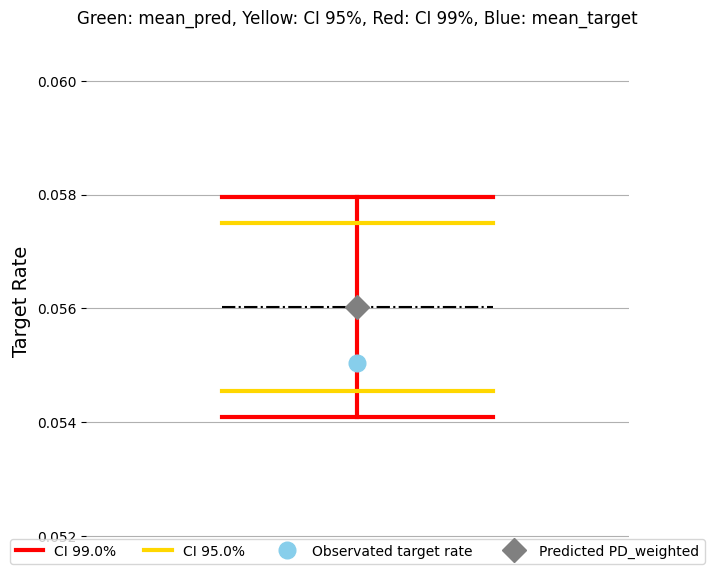

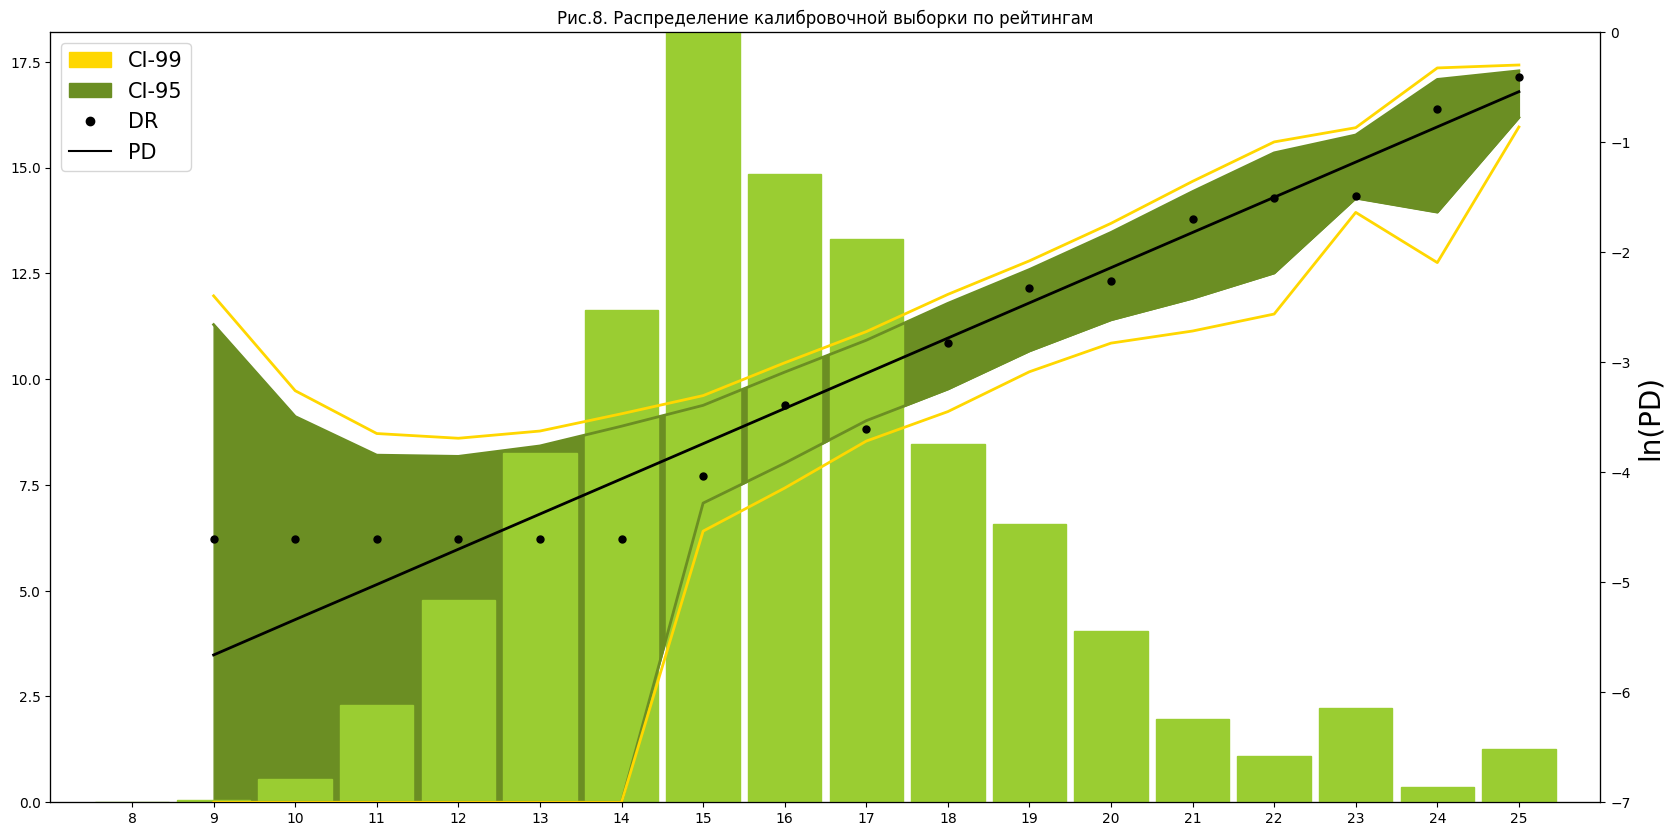

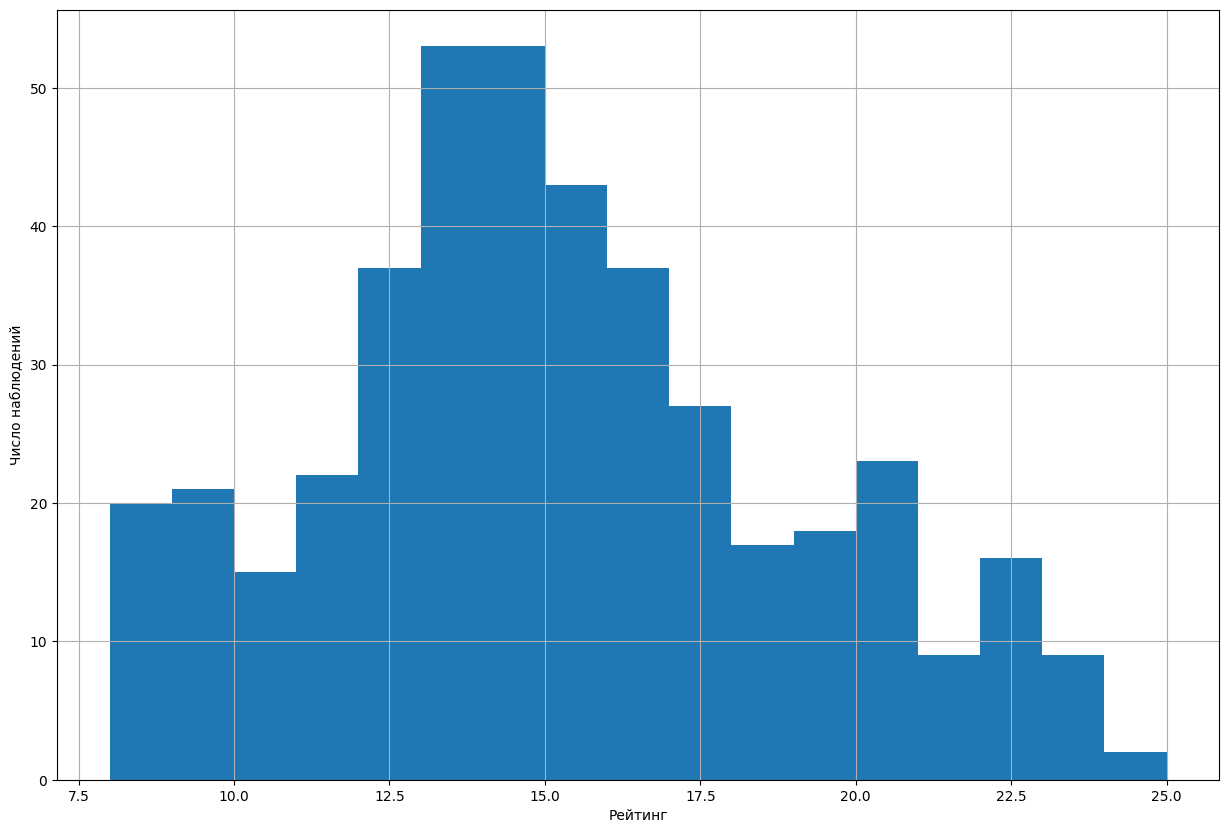

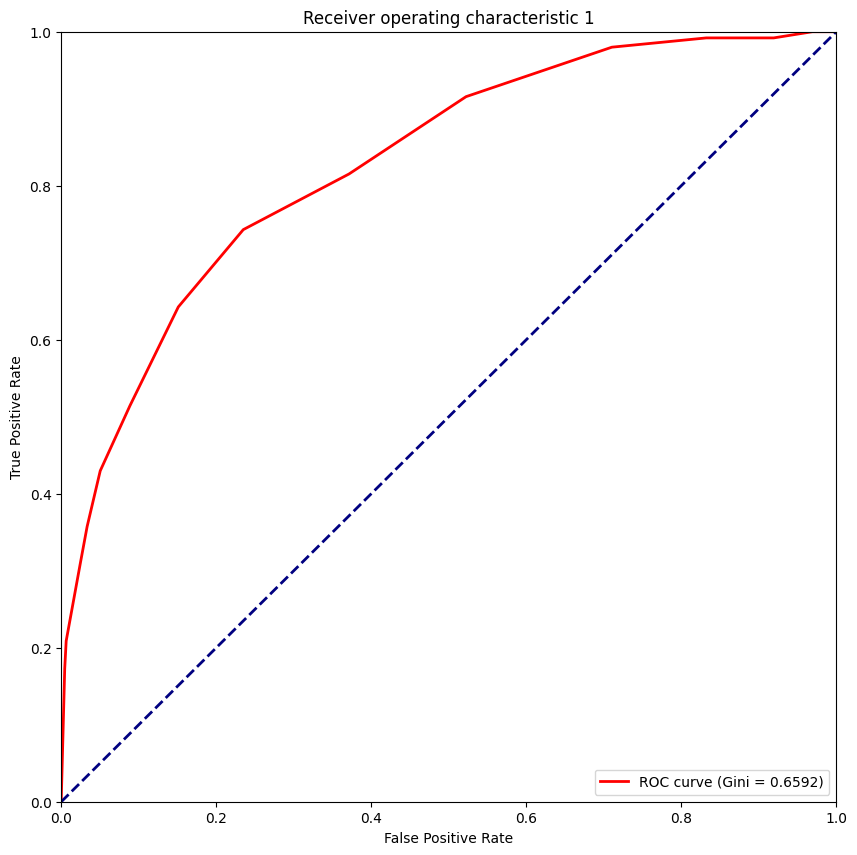


 --- Gini ---
Зеленый


In [29]:
print('\n --- TTC ---')
TTC(df_final,'_new_pred', TTC_value)
print('\n --- Calibration Curve ---')
calibration_curve(df_final, '_new_rating', '_new_pred', target_col, '')
print('\n --- HHI ---')
display(HHI(df_final['_new_rating_PIT'], j=26))
print('\n --- ROCAUC ---')
roc(df_final['target'], df_final['_new_pred'], ' 1')
print('\n --- Gini ---')
ss = gini_dynamic(df_final, target_col, '_new_pred', 'rating_assignment_date', 1, 1, False, 'quarter')

In [ ]:
pred = df_final['_new_pred'].to_numpy()
y    = df_final['target'].to_numpy()

In [ ]:
n_bootstraps = 1000
rng_seed = 42
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(pred), len(pred))
    if len(np.unique(y[indices])) < 2:
        continue

    score = roc_auc_score(y[indices], pred[indices])
    bootstrapped_scores.append(score)

np.quantile(bootstrapped_scores, 0.05) * 2 - 1, np.mean(bootstrapped_scores) * 2 - 1

#### 7.8.2 - Валидация PIT

In [ ]:
HHI(df_final[df_final._new_pred_PIT.notnull()]['_new_rating_PIT'], j=26)

In [ ]:
print('\n --- TTC ---')
TTC(df_final[df_final['_new_pred_PIT'].notnull()],'_new_pred_PIT', PIT_value)
print('\n --- Calibration Curve ---')
calibration_curve(df_final[df_final._new_pred_PIT.notnull()], '_new_rating_PIT', '_new_pred_PIT', target_col, '')
print('\n --- HHI ---')
HHI(df_final[df_final._new_pred_PIT.notnull()]['_new_rating_PIT'], j=26)
print('\n --- ROCAUC ---')
roc(df_final.query('_new_pred_PIT.isna() == False', engine = 'python')['target'],
    df_final.query('_new_pred_PIT.isna() == False', engine = 'python')['_new_pred_PIT'], ' 1')
print('\n --- Gini ---')
ss = gini_dynamic(df_final[df_final['_new_pred_PIT'].notnull()], target_col, '_new_pred_PIT', 'rating_assignment_date', 1, 1, False, 'quarter')

In [ ]:
pred = df_final[df_final['_new_pred_PIT'].notnull()]['_new_pred'].to_numpy()
y = df_final[df_final['_new_pred_PIT'].notnull()]['target'].to_numpy()

#### 7.8.3 - Gini

In [ ]:
n_bootstraps = 1000
rng_seed = 42
bootstrapped_scores = []

rng = np.random.RandomState(rng_seed)
for i in range(n_bootstraps):
    indices = rng.randint(0, len(pred), len(pred))
    if len(np.unique(y[indices])) < 2:
        continue

    score = roc_auc_score(y[indices], pred[indices])
    bootstrapped_scores.append(score)

np.quantile(bootstrapped_scores, 0.05) * 2 - 1, np.mean(bootstrapped_scores) * 2 - 1